# POP MOC(z) for 1-degree
 - Compute MOC(z) offline from POP history files

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
from functools import partial
import glob
import dask
import cf_xarray
import matplotlib.pyplot as plt
%matplotlib inline

from MOCutils import popmoc

### Read in OGCM history file & MOC template file

In [2]:
fpop = '/glade/scratch/yeager/POP_MOC/g210.GIAF_JRA.v14.gx1v7.02.pop.h.0157-01.nc'
ds = xr.open_dataset(fpop)
fmoc = '/glade/u/home/yeager/analysis/python/POP_MOC/moc_template.nc'
ds_moctemp = xr.open_dataset(fmoc)

### Compute Volume Fluxes

In [3]:
u_e = ds['UVEL']
v_e = ds['VVEL']
w_e = ds['WVEL']
u_e = u_e.where(u_e<1.e30)
v_e = v_e.where(v_e<1.e30)
w_e = w_e.where(w_e<1.e30)
u_e.values[np.isnan(u_e.values)]=0.0
v_e.values[np.isnan(v_e.values)]=0.0
w_e.values[np.isnan(w_e.values)]=0.0

In [4]:
# grid-oriented volume fluxes in m^3/s
uflux = (u_e)*ds['DYU']*ds['dz']/1.e6  
vflux = (v_e)*ds['DYU']*ds['dz']/1.e6    
wflux = (w_e)*ds['TAREA']/1.e6

#### wflux is defined at top of T-cell ==> need to add an extra level corresponding to zero values at ocean floor.

In [5]:
wflux_bot = xr.zeros_like(wflux.isel(z_w_top=-1))
wflux_bot['z_w_top'] = ds.z_w_bot[-1].data
wflux = xr.concat([wflux,wflux_bot],dim='z_w_top')

In [6]:
wflux.z_w_top

<xarray.DataArray 'z_w_top' (z_w_top: 61)>
array([     0.   ,   1000.   ,   2000.   ,   3000.   ,   4000.   ,   5000.   ,
         6000.   ,   7000.   ,   8000.   ,   9000.   ,  10000.   ,  11000.   ,
        12000.   ,  13000.   ,  14000.   ,  15000.   ,  16000.   ,  17019.682,
        18076.129,  19182.125,  20349.932,  21592.344,  22923.312,  24358.453,
        25915.58 ,  27615.26 ,  29481.47 ,  31542.373,  33831.227,  36387.473,
        39258.047,  42498.887,  46176.656,  50370.688,  55174.91 ,  60699.668,
        67072.86 ,  74439.805,  82960.695,  92804.35 , 104136.82 , 117104.016,
       131809.36 , 148290.08 , 166499.2  , 186301.44 , 207487.39 , 229803.9  ,
       252990.4  , 276809.84 , 301067.06 , 325613.84 , 350344.88 , 375189.2  ,
       400101.16 , 425052.47 , 450026.06 , 475012.   , 500004.7  , 525000.94 ,
       549999.06 ], dtype=float32)
Coordinates:
  * z_w_top  (z_w_top) float32 0.0 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Attributes:
    long_name:  depth from surface to top of layer
    units:      centimeters
    positive:   down
    valid_min:  0.0
    valid_max:  525000.94

### Customize Region Mask

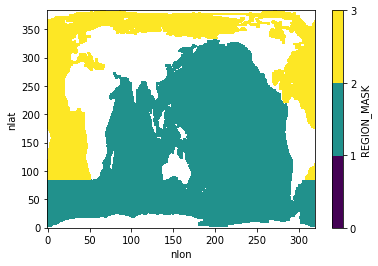

In [9]:
## Define MOC region mask with legend:
rmask = ds.REGION_MASK
rmasknew = rmask.where(rmask>0)
rmasknew = xr.where((rmask>0),1,rmasknew)
rmasknew = xr.where((rmask>=6) & (rmask<=11),2,rmasknew)
rmasknew.plot(levels=[0,1,2,3]);
rmasknew.attrs['legend'] = {0:"Global",1:"IndoPac+SO",2:"Atlantic"}

### Compute MOC

##### Compute Zonal Integral of vertical flux

In [10]:
%%time
wflux_zonint = popmoc.wflux_zonal_int(wflux,rmasknew,ds_moctemp.lat_aux_grid)

CPU times: user 29 s, sys: 28.2 s, total: 57.3 s
Wall time: 59 s


##### Compute Meridional Cumulative Sum

In [11]:
MOCnew = wflux_zonint.cumsum(dim='lat_aux_grid')/1.e6

### Evaluate difference from online-computed MOC

In [12]:
MOCorig = ds.MOC.isel(moc_comp=0).rename({'moc_z':'z_w_top'})

In [13]:
MOCdiff = MOCnew.isel(transport_reg=[0,2]) - MOCorig

/glade/scratch/yeager/tmp/ipykernel_186853/539977962.py:11: UserWarning: linewidths is ignored by contourf
  cntr1 = ax.contourf(MOCnew.lat_aux_grid, MOCnew.z_w_top/1.e5, MOCnew.isel(time=0,transport_reg=0),levels=mnlevs, linewidths=0.5, cmap=mycmap,extend='max')
/glade/scratch/yeager/tmp/ipykernel_186853/539977962.py:22: UserWarning: linewidths is ignored by contourf
  cntr2 = ax.contourf(MOCorig.lat_aux_grid, MOCorig.z_w_top/1.e5, MOCorig.isel(time=0,transport_reg=0),levels=mnlevs, linewidths=0.5, cmap=mycmap,extend='max')


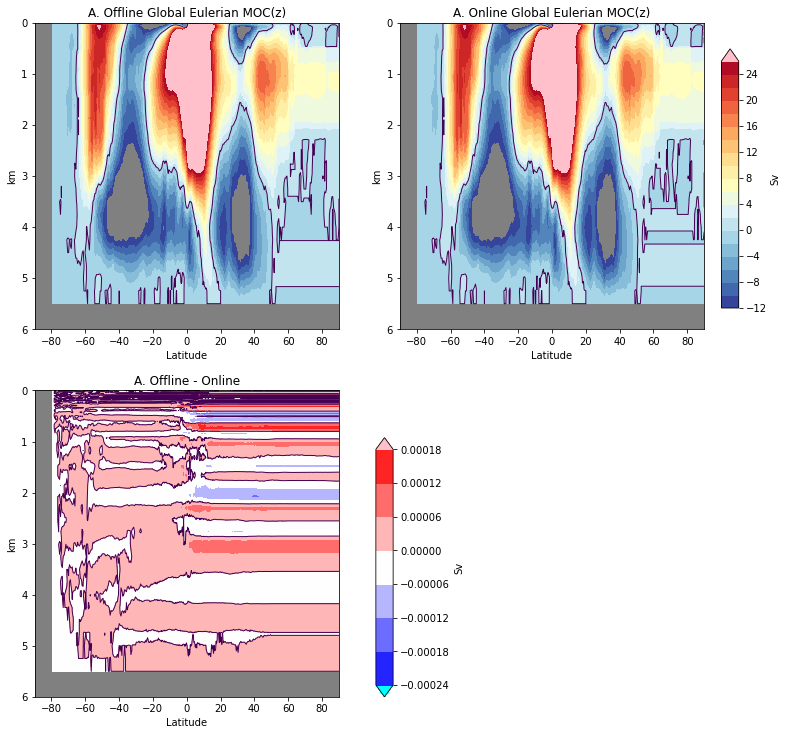

In [14]:
# Plot MOC

fig = plt.figure(figsize=(12,12))
mnlevs = np.arange(0,20,1)*2. - 12.
mycmap = copy.copy(plt.cm.RdYlBu_r)
xlim=[-30,70]
ylim=[6,0]

ax = fig.add_subplot(2,2,1)
ax.set_title('A. Offline Global Eulerian MOC(z)')
cntr1 = ax.contourf(MOCnew.lat_aux_grid, MOCnew.z_w_top/1.e5, MOCnew.isel(time=0,transport_reg=0),levels=mnlevs, linewidths=0.5, cmap=mycmap,extend='max')
ax.contour(MOCnew.lat_aux_grid, MOCnew.z_w_top/1.e5, MOCnew.isel(time=0,transport_reg=0),levels=[0.], linewidths=1)
cntr1.cmap.set_over('pink')
ax.set_ylim([6,0])
ax.set_xlim([-90,90])
ax.set_xlabel('Latitude')
ax.set_ylabel('km')
ax.set_facecolor('grey')

ax = fig.add_subplot(2,2,2)
ax.set_title('A. Online Global Eulerian MOC(z)')
cntr2 = ax.contourf(MOCorig.lat_aux_grid, MOCorig.z_w_top/1.e5, MOCorig.isel(time=0,transport_reg=0),levels=mnlevs, linewidths=0.5, cmap=mycmap,extend='max')
ax.contour(MOCorig.lat_aux_grid, MOCorig.z_w_top/1.e5, MOCorig.isel(time=0,transport_reg=0),levels=[0.], linewidths=1)
cntr2.cmap.set_over('pink')
ax.set_ylim([6,0])
ax.set_xlim([-90,90])
ax.set_xlabel('Latitude')
ax.set_ylabel('km')
ax.set_facecolor('grey')

diffcmap = copy.copy(plt.cm.bwr)
difflevs = np.arange(0,20,1)*2. - 12.
ax = fig.add_subplot(2,2,3)
ax.set_title('A. Offline - Online')
cntr3 = ax.contourf(MOCdiff.lat_aux_grid, MOCdiff.z_w_top/1.e5, MOCdiff.isel(time=0,transport_reg=0),cmap=diffcmap,extend='both')
ax.contour(MOCdiff.lat_aux_grid, MOCdiff.z_w_top/1.e5, MOCdiff.isel(time=0,transport_reg=0),levels=[0.], linewidths=1)
cntr3.cmap.set_over('pink')
cntr3.cmap.set_under('cyan')
ax.set_ylim([6,0])
ax.set_xlim([-90,90])
ax.set_xlabel('Latitude')
ax.set_ylabel('km')
ax.set_facecolor('grey')


fig.subplots_adjust(bottom=0.1,right=0.9)
cbar_ax = fig.add_axes([0.92, 0.55, 0.02, 0.3])
fig.colorbar(cntr1, cax=cbar_ax, label='Sv', orientation='vertical')
cbar_ax2 = fig.add_axes([0.52, 0.1, 0.02, 0.3])
fig.colorbar(cntr3, cax=cbar_ax2, label='Sv', orientation='vertical')